# Сборный проект

## Описание проекта

Работа в интенет магазине. Есть исторические данные о продажах игр на различных платформах. На основании этих данных надо сделать предположение о том, что будет в 2016-2017 годах.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Описание данных
    Name — название игры
    Platform — платформа
    Year_of_Release — год выпуска
    Genre — жанр игры
    NA_sales — продажи в Северной Америке (миллионы проданных копий)
    EU_sales — продажи в Европе (миллионы проданных копий)
    JP_sales — продажи в Японии (миллионы проданных копий)
    Other_sales — продажи в других странах (миллионы проданных копий)
    Critic_Score — оценка критиков (максимум 100)
    User_Score — оценка пользователей (максимум 10)
    Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## План выполнения
1. [Открытие файла с данными и их изучение](#step_1) 
2. [Подготовка данных](#step_2) 
3. [Исследовательский анализ данных](#step_3)
4. [Портрет пользователя каждого региона](#step_4)
5. [Проверка гипотезы](#step_5)
6. [Общий вывод](#step_6)

### Импортирование библиотек и выгрузка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import normaltest
from scipy.stats import f_oneway
import warnings
warnings.filterwarnings('ignore')

Выгрузка данных <a id='step_1'></a>

In [2]:
df = pd.read_csv('')
df.info()
df.head(10)
df_copy = df.copy(deep=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В данных 11 колонок, в которых присутствуют нулевые значения. Не все типы данных соответсвуют своим значениям.

### Подготовка данных

<b>Замена названий столбцов, приведение к нижнему регистру.</b> <a id='step_2'></a>

In [3]:
columns_list = df.columns.str.lower()
df.columns = columns_list
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

<b>Преобразование данных к нужному типу.</b>

In [4]:
# Преобразование к int
df['year_of_release'] = pd.to_numeric(df['year_of_release'],errors='coerce')
df['critic_score'] = pd.to_numeric(df['critic_score'],errors='coerce')


<b>Обработка пропусков.</b>

In [5]:
df.isna().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
dtype: float64

In [6]:
# Удаление строк без имени и года релиза
df.dropna(subset = ['name','year_of_release','genre'],inplace=True)
df[['name','year_of_release','genre']].isna().sum()

name               0
year_of_release    0
genre              0
dtype: int64

Удалила строки без имени и года выпуска,  потому что не имеет смысла эти данные анализировать и их суммарно мало, относительно всего дадасета. 

In [7]:
df.loc[(df['user_score'] == 'tbd'), 'user_score'] = np.NaN 

tbd - to be determined - пока не определён. Мы не можем заменять большое количество пропусков медианой или средним, это может повлиять на статистические показатели далее. Поэтому tbd был заменён на NaN в столбце 'user_score'.

Конкретно в случае с tbd мы имеем право заменить его на NaN, потому что эту информацию нам нигде не достать. Есть примлимые способы заменить отсутствующие данные медианой в соответствии со схожим параметром (user_score и critic_score) или по повторяющимся именам в столбце name.

In [8]:
%%time
# Замена пропусков на медианные значения в соответствии с именем
for name in df['name'].unique():
    median_us_sc = df.loc[df['name'] == name, 'user_score'].median()
    median_cr_sc = df.loc[df['name'] == name, 'critic_score'].median()
    #df.loc[(df['name'] == name)&(df['user_score'].isna()),'user_score'] = median_us_sc
    #df.loc[(df['name'] == name)&(df['critic_score'].isna()),'critic_score'] = median_cr_sc
    #if df['name'] in name:
    df['user_score'].fillna(median_us_sc)
    df['critic_score'].fillna(median_cr_sc)
    
print('Пропуски после critic_score:', df['critic_score'].isna().sum() )    
print('Пропуски после user_score:', df['user_score'].isna().sum() )    

Пропуски после critic_score: 8461
Пропуски после user_score: 8981
CPU times: user 1min 3s, sys: 23.5 ms, total: 1min 3s
Wall time: 1min 3s


In [9]:
df_copy.columns = df_copy.columns.str.lower()
df_copy['critic_score'] = pd.to_numeric(df_copy['critic_score'],errors='coerce')
df_copy['user_score'] = pd.to_numeric(df_copy['user_score'],errors='coerce')

In [10]:
df_copy.groupby('name')['user_score'].transform('median')

0        8.0
1        NaN
2        8.3
3        8.0
4        NaN
        ... 
16710    NaN
16711    NaN
16712    NaN
16713    NaN
16714    NaN
Name: user_score, Length: 16715, dtype: float64

In [11]:
# Замена пропущенных значений медианой в соответсвии оценкой критиков
for user_score in df['user_score'].unique():
    median_cr_sc = df.loc[df['user_score'] == user_score, 'critic_score'].median()
    #print(name, median_cr_sc)
    df.loc[(df['user_score'] == user_score)&(df['critic_score'].isna()),'critic_score'] = median_cr_sc    
print('Пропуски после:', df['critic_score'].isna().sum() ) 
df['user_score'] = pd.to_numeric(df['user_score'],errors='coerce')

Пропуски после: 7903


In [12]:
df.groupby('genre')['rating'].value_counts()

genre         rating
Action        T          670
              M          596
              E10+       468
              E          410
              AO           1
              EC           1
Adventure     E          159
              T          114
              M           98
              E10+        67
              EC           2
Fighting      T          357
              M           48
              E10+        19
              E            8
Misc          E          449
              T          228
              E10+       166
              M           13
              EC           5
              K-A          1
Platform      E          354
              E10+       141
              T           63
              M            3
Puzzle        E          284
              E10+        42
              T           10
Racing        E          576
              T          167
              E10+        95
              M           18
Role-Playing  T          415
              M       


В столбце с возрастным рейтингом много пропусков. Некоторые из них можно заменить в соответствии с жанром. Сделаем это, где есть явное преобладание определённого рейтинга в отдельном жанре. Остальное заполним фразой 'no rating', 

In [13]:
df.loc[(df['genre'] == 'Sports')&(df['rating'].isna()),'rating'] = 'E'
df.loc[(df['genre'] == 'Racing')&(df['rating'].isna()),'rating'] = 'E'
df.loc[(df['genre'] == 'Puzzle')&(df['rating'].isna()),'rating'] = 'E'
df['rating'] = df['rating'].fillna('No rating')

<b>Подсчёт суммарных продаж по регионам.</b>

In [14]:
df['sum_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales']

В данных были заменены типы на int, где требовалось. Удалены строки без имени и года релиза, так как без этих данных они не столь важны. Заменили пропуски на медианные значения, где была такая возможность (повторялись названия игр или были рейтинги, в своответствии с которыми можно было заполнить пропуски).

 Информация о названии игр, её жанре и годах выпуска может отсуствовать из-за невнимательности. Восстановить эти данные самостоятельно нет возможности. Данных о возрастном рейтинге может не быть из за того, что сам рейтинг появился в 1994 году, а часть игр была выпущена до этого момента. Причин отсутствия оценок критиков и пользователей могут быть разнообразными: не популярность платформы, большой возраст игры, слишком новая игра на момент сбора данных.


### Исследовательский анализ данных

<b>Выпуск игр по годам</b><a id='step_3'></a>

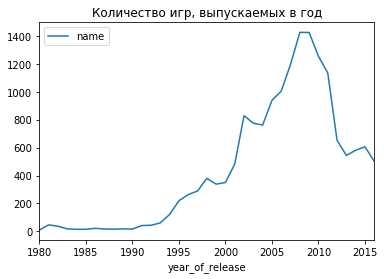

In [15]:
df.groupby('year_of_release').agg({'name':'count'}).plot(title='Количество игр, выпускаемых в год')
plt.show()

Играми, выпущенными до 2000 года можно пренебречь, их было доатсаточно мало.

<b>Продажи игр на различных платформах</b>

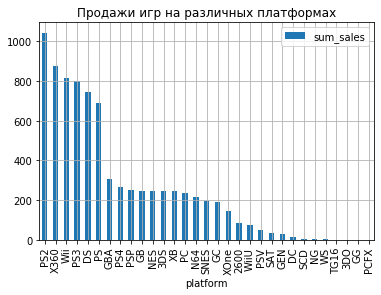

In [16]:
df.groupby('platform').agg({'sum_sales':'sum'}).sort_values(by='sum_sales',ascending = False).plot( kind = 'bar', title='Продажи игр на различных платформах', grid=True)
plt.show()

Рассмотрим те платформы, у которых продажи были больше 700млн: PS2, PS, PS3, DS, Wii, X360.

In [17]:
platform_list = ['PS2', 'PS', 'PS3', 'DS', 'Wii', 'X360']
for platform in platform_list:
    df_loop = df.query('platform in @platform')
    min_sales = df_loop.groupby('year_of_release')['sum_sales'].sum().quantile(0.25)
    print('25% квантиль',platform, min_sales)

25% квантиль PS2 30.002500000000047
25% квантиль PS 13.087499999999999
25% квантиль PS3 29.090000000000003
25% квантиль DS 13.164999999999996
25% квантиль Wii 5.659999999999999
25% квантиль X360 26.422499999999996



 Для различных платформ подсчитали 25 квантиль для суммарных продаж по годам - это и будет наш критерий по определеню среднего срока популярности платформы.


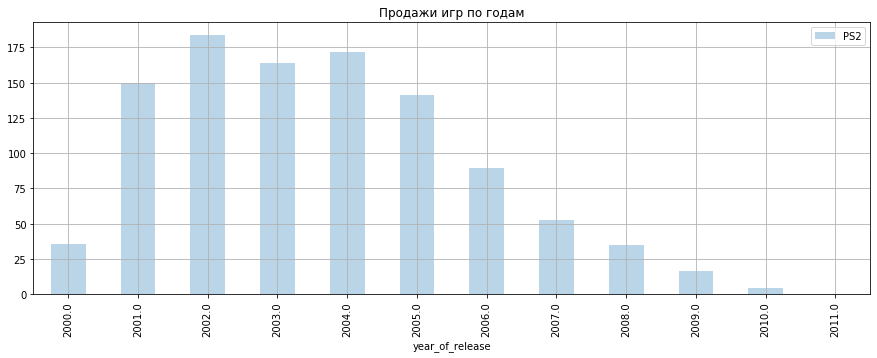

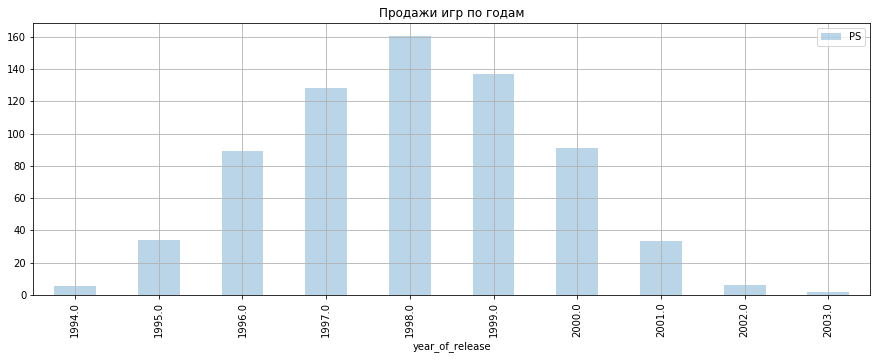

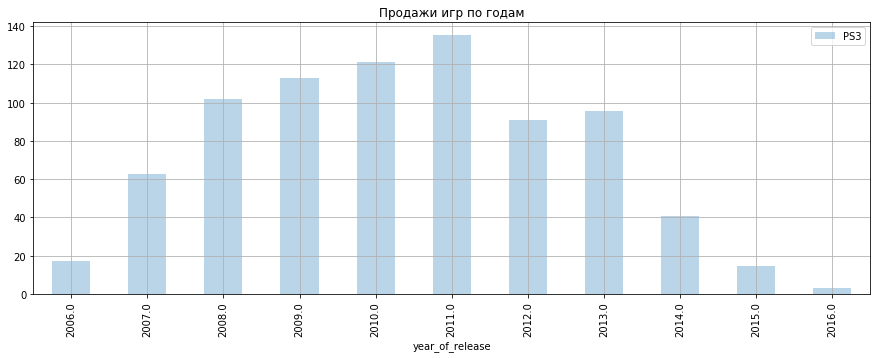

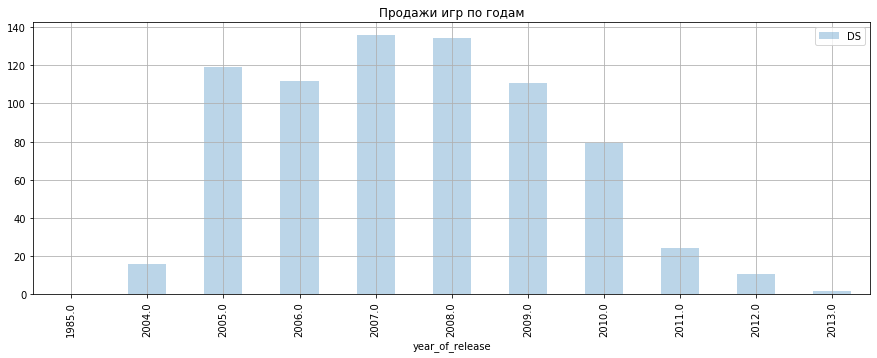

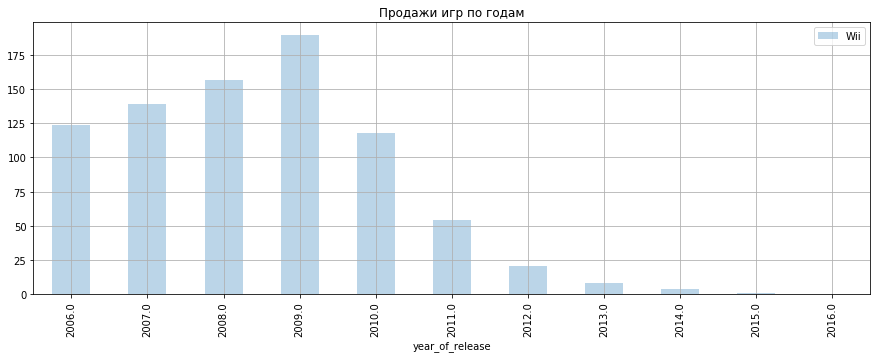

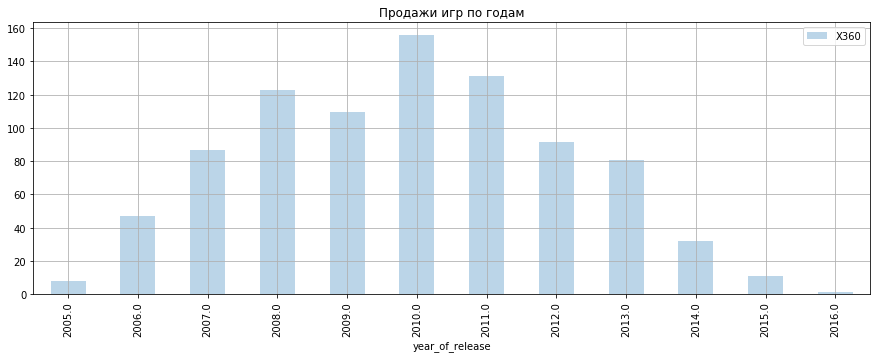

In [18]:

for platform in platform_list:
    df_new = df.query('platform in @platform')
    df_new.groupby('year_of_release')['sum_sales'].sum().plot(x='year_of_release', y='sum_sales', label=platform, kind='bar', figsize=(15, 5), legend=True, alpha = 0.3,title='Продажи игр по годам', grid=True)
    plt.show()

На графиках видно, что платформы были популярны примерно по 5 лет, затем обновлялись и игры выпускали уже на новые платформы.

Будем считать актуальными данные за 2008-2016 года.

Далее рассмотрим потенциально прибыльные платформы: PS4, WIIU, DS, X360.


Для PS2 уровень продаж определили как 30 млн. Выше этого уровня продажи были с 2001 по 2007 год. Для PS уровень продаж определили как 13 млн. Выше этого уровня продажи были с 1995 по 2001 год. В среднем 6-7 лет игры на платформы продаются активно.


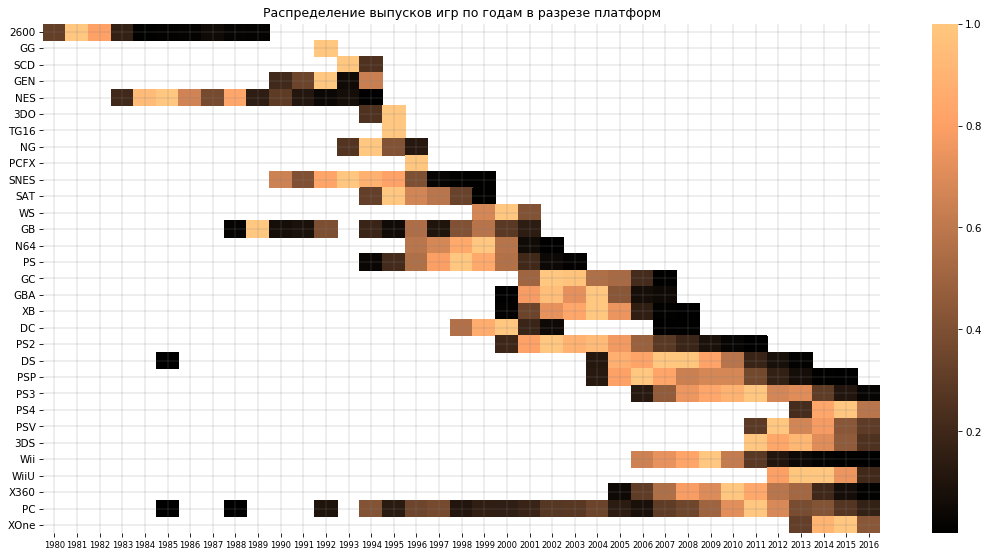

In [19]:
sort_platform = df.groupby('platform', as_index=False).agg({'year_of_release':'max'})
top_6_pivot = pd.pivot_table(df.query('year_of_release > 0')\
                   .assign(year_of_release = lambda row: row['year_of_release'].astype(int)), 
               values = 'sum_sales', columns = 'year_of_release', index = 'platform', aggfunc='sum')

#сортировка по максимальному году платформы		   
viz_top_6 = top_6_pivot\
    .reset_index()\
    .merge(sort_platform, on='platform')\
    .sort_values(by='year_of_release')\
    .drop('year_of_release', axis=1)\
    .reset_index(drop=True)\
    .set_index('platform')

fig, ax = plt.subplots(figsize=(18, 9), dpi=75)
ax.set_title('Распределение выпусков игр по годам в разрезе платформ');
sns.heatmap(viz_top_6.apply(lambda row: row / row.max(), axis=1), cmap='copper', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(rotation=0, labels=viz_top_6.columns, fontsize=8)
ax.set_yticklabels(rotation=0, labels=viz_top_6.index)
ax.grid(color='grey', linewidth=0.25)
plt.show()


Далее рассмотрим потенциально прибыльные платформы: PS4, WIIU, 3DS, XOne. Так как они наиболее новые поколения предыдущих лидеров продаж.
    
Будем считать актуальными данные за 2009-2016 года.


In [20]:
# Отсавим данные для интересующих нас платформ за 2009-2016 года.
platform_list = ['PS4',  'WiiU', '3DS',  'XOne']
df_08_16 = df.query('(year_of_release > 2008)and(platform in @platform_list)')
df_08_16.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,No rating,12.25
33,Pokemon X/Pokemon Y,3DS,2013.0,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,No rating,13.82
40,Mario Kart 7,3DS,2011.0,Racing,5.03,4.02,2.69,0.91,85.0,8.2,E,11.74
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,10.65
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014.0,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,No rating,10.94
53,Super Mario 3D Land,3DS,2011.0,Platform,4.89,3.00,2.14,0.78,90.0,8.4,E,10.03
62,New Super Mario Bros. 2,3DS,2012.0,Platform,3.66,3.14,2.47,0.63,78.0,7.2,E,9.27
73,Animal Crossing: New Leaf,3DS,2012.0,Simulation,2.03,2.36,4.39,0.39,88.0,8.7,E,8.78
77,FIFA 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,7.30
87,Star Wars Battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,No rating,6.70


<b>"Ящик с усами" для данных о суммарных продажах.</b>

Платформа PS4


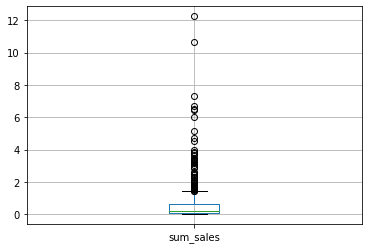

Платформа WiiU


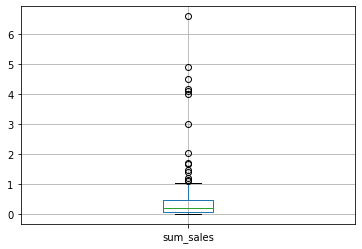

Платформа 3DS


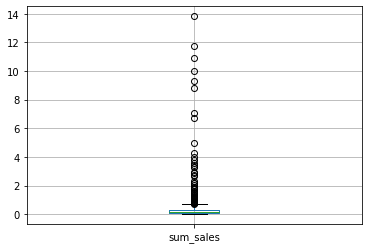

Платформа XOne


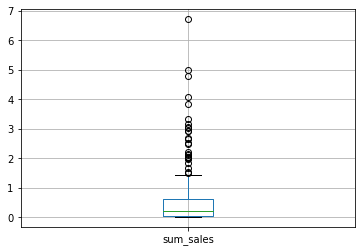

In [21]:
for platform in platform_list:
    df_08_16.loc[df_08_16['platform'] == platform].boxplot(column='sum_sales')
    print('Платформа', platform)
    plt.show()

На представленных графиках "ящик с усами" для различных платформ видно, что в среднем продажи игр не выходят за пределы 1.5 млн. Бывают выбросы до 4 млн, но это скорее редкость. Меньше всего продажи на платформе DS.

<b>Влияние отзывов на продажи.</b>

,user_score,critic_score,sum_sales
user_score,1.000000,0.566949,-0.031261
critic_score,0.566949,1.000000,0.405733
sum_sales,-0.031261,0.405733,1.000000


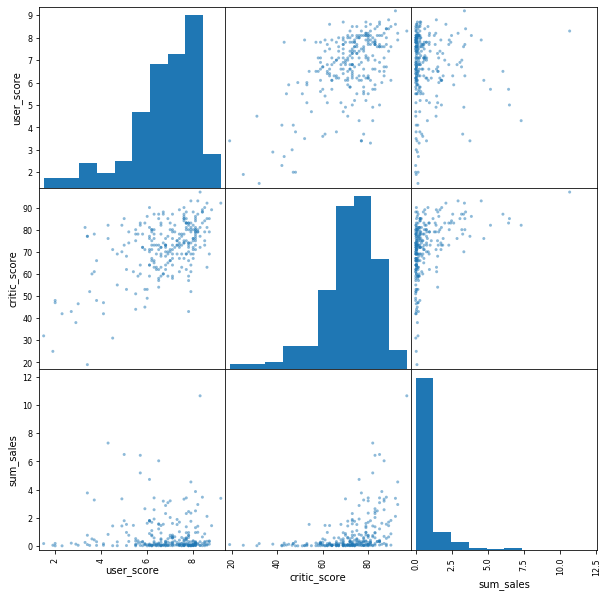

In [22]:
# Построение диаграммы рассеяния для исследуемых данных
df_ps4 = df_08_16.query('platform == "PS4"')[['user_score','critic_score','sum_sales']]
pd.plotting.scatter_matrix(df_ps4, figsize=(10,10))
df_ps4.corr()

In [23]:
df_3ds = df_08_16.query('platform == "3DS"')[['user_score','critic_score','sum_sales']]
df_3ds.corr()

,user_score,critic_score,sum_sales
user_score,1.000000,0.759089,0.224307
critic_score,0.759089,1.000000,0.337703
sum_sales,0.224307,0.337703,1.000000


Глядя на коэффициенты корреляции отзывов критиков и пользователей с продажами игры, можно сказать, что продажи больше зависят от отзывов критиков(независимо от платформы). 

<b>Зависимость продаж от жанров игр.</b>

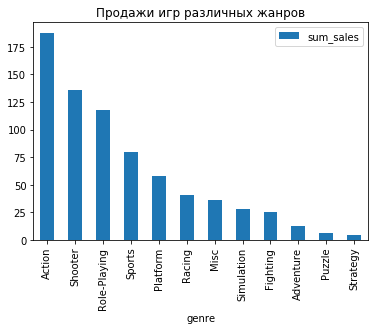

In [24]:
df_08_16.groupby('genre').agg({'sum_sales':'sum'}).sort_values(by='sum_sales',ascending = False).plot(kind = 'bar', title='Продажи игр различных жанров')
plt.show()

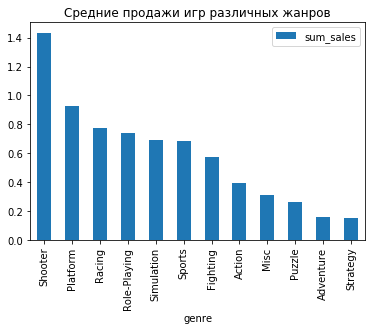

In [25]:
df_08_16.groupby('genre').agg({'sum_sales':'mean'}).sort_values(by='sum_sales',ascending = False).plot(kind = 'bar', title='Средние продажи игр различных жанров')
plt.show()

Игры жанра Action продаются лучше всего, следом идут Shotter, Sports и Role-Playing.

Хуже всего люди покупают Strategy и Puzzle.

Игры, которые продаются лучше, проходятся пользователями быстрее, чем, например, стратегии, и поэтому их чаще покупают. 


  Построили ещё график, оторажающий средние значени продаж по различным жанрам. Они ненмого отличаются. Лидер продаж - Shooter. В целом, пятёрка победителей не сильно отличается на ооих графиках. На первом графике больше влияют выбросы: наиболее популярные игры есть всегда, но это удача разработчиков игр. А нам надо рассматривать лидеров продаж в среднем, для более надёжного результата.
   

### Портрет пользователя каждого региона

<b>Самые популярные платформы для различных регионов.</b><a id='step_4'></a>

In [26]:
df_region = df.query('year_of_release > 2008')

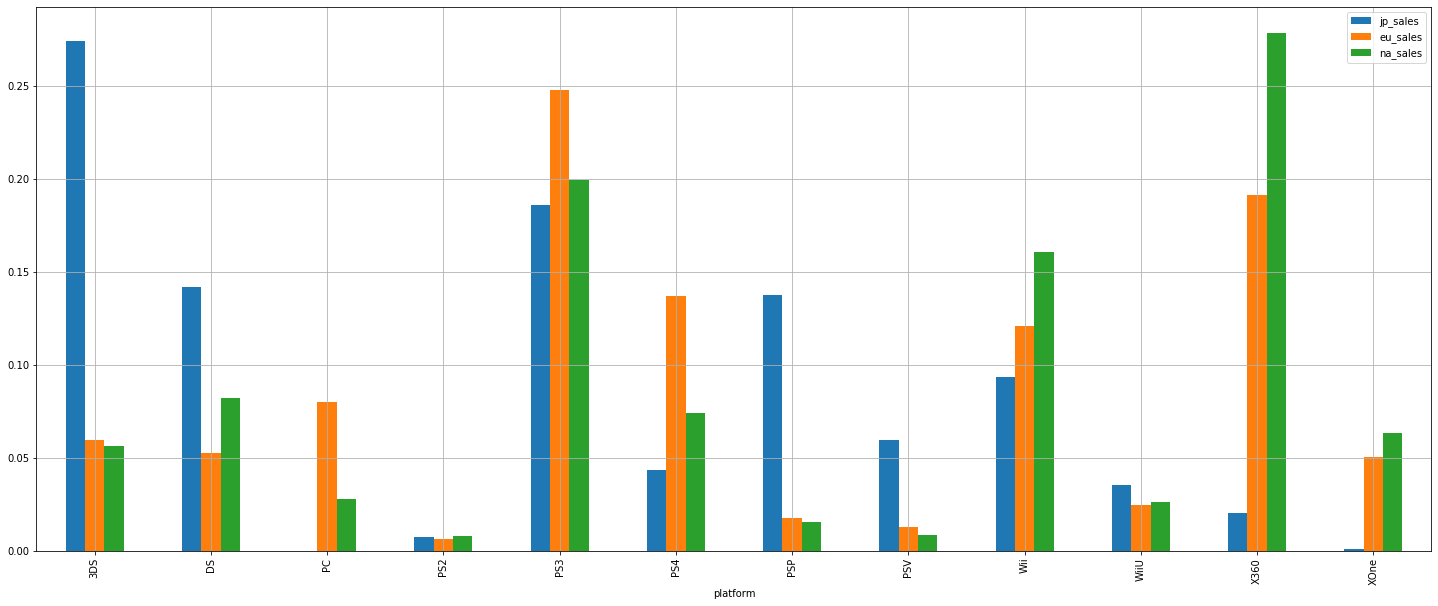

In [27]:
df_reg_plat = df_region.groupby('platform')[['jp_sales','eu_sales','na_sales']].sum()
df_reg_plat[['jp_sales','eu_sales','na_sales']] = df_reg_plat[['jp_sales','eu_sales','na_sales']] / df_region[['jp_sales','eu_sales','na_sales']].sum()
df_reg_plat.plot(kind = 'bar',legend=True, grid = True, figsize = (25,10))
plt.show()

Самые популярные платформы:
    - Северная Америка - X360, Wii, PS3;  
    - Европа - PS3, X360, Wii;
    - Япония - 3DS, DS, PS3.
    
Топ 5: X360, Wii, PS3, 3DS, DS.    

<b>Самые популярные жанры для различных регионов.</b>

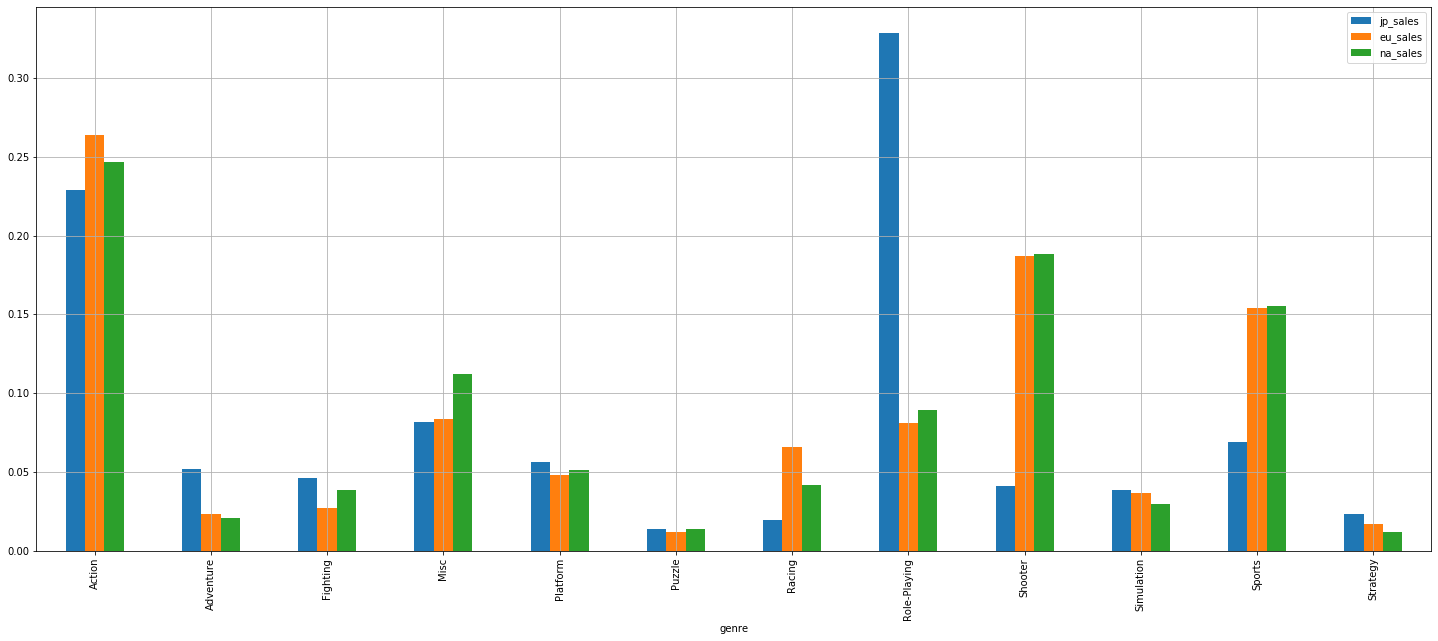

In [28]:
df_reg_genre = df_region.groupby('genre')[['jp_sales','eu_sales','na_sales']].sum()
df_reg_genre[['jp_sales','eu_sales','na_sales']] = df_reg_genre[['jp_sales','eu_sales','na_sales']] / df_region[['jp_sales','eu_sales','na_sales']].sum()
df_reg_genre.plot(kind = 'bar',legend=True, grid = True, figsize = (25,10))
plt.show()

Самые популярные жанры:
    - Северная Америка - Action, Shooter, Sports;  
    - Европа - Action, Shooter, Sports;
    - Япония - Role-Playing, Action, Misc.
    
Топ 5: Action, Shooter, Sports, Misc, Role-Playing. 

<b>Влияние рейтинга ESRB на продажи в отдельном регионе.</b>

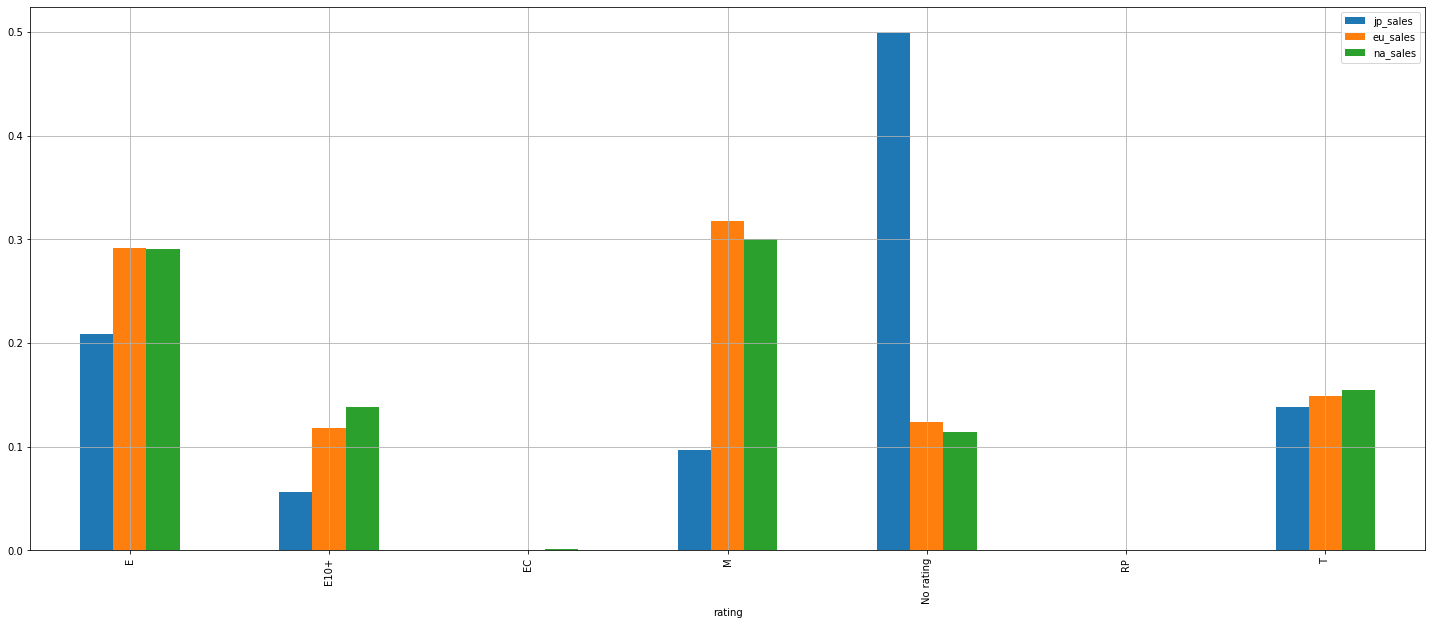

In [29]:
df_reg_rating = df_region.groupby('rating')[['jp_sales','eu_sales','na_sales']].sum()
df_reg_rating[['jp_sales','eu_sales','na_sales']] = df_reg_rating[['jp_sales','eu_sales','na_sales']] / df_region[['jp_sales','eu_sales','na_sales']].sum()
df_reg_rating.plot(kind = 'bar',legend=True, grid = True, figsize = (25,10))
plt.show()

Рейтинг ESRB:
    - «EC» («Early childhood») — «Для детей младшего возраста»
    - «E» («Everyone») — «Для всех»
    - «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
    - «T» («Teen») — «Подросткам»
    - «M» («Mature») — «Для взрослых»
    - «AO» («Adults Only 18+») — «Только для взрослых»

Игры "для всех" или "для взрослых" продаются лучше всего, потому что это подавляющее большинтсво платёжеспособных пользователей.

Подводя итоги исследования портрета пользователей из разных регионов можно сказать следующее:
    - жители Северной Амерки по предпочтениям ближе к европейцам, чем к японцам;
    - популярность игр зависит от популярности платформ в конкретном регионе;
    - из-за своей отдалённости, Японские пользователи отличаются по вкусам от остальных;
    - на продаваемость игры может влиять тип воспитания и традиции в отдельном регионе.

 В Японии очень много игр продаётся без рейтинга. Возмжно, причина этому в том, что у них есть свой рейтинг и часть игр они продают локально на своей территории.


,jp_sales
rating,
No rating,183.24
E,76.75
T,50.59
M,35.63
E10+,20.82
EC,0
RP,0


,eu_sales
rating,
M,326.5
E,299.85
T,153.28
No rating,127.86
E10+,121.63
RP,0.03
EC,0


,na_sales
rating,
M,440.86
E,426.42
T,227.11
E10+,202.94
No rating,167.31
EC,1.32
RP,0


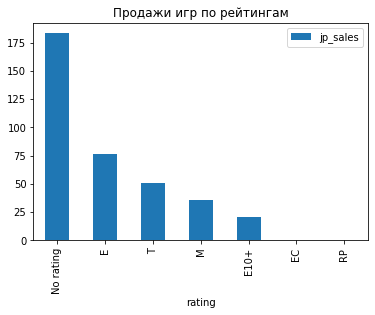

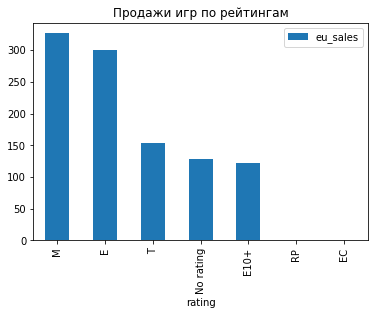

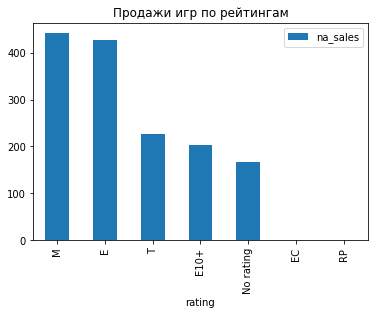

In [30]:
# можно сделать три отдельных таблички, но отсортированных
for region in ['jp_sales','eu_sales','na_sales']:
    display(df_region\
                .groupby('rating')\
                .agg({region: 'sum'})\
                .sort_values(by=region, ascending=False)\
                .style.bar(color='#98C6FF'))
    
# еще удобнее совместить три таблички в одну или сделать три маленьких графика
for region in ['jp_sales','eu_sales','na_sales']:
    df_region.groupby('rating').agg({region: 'sum'}).sort_values(by=region, ascending=False).plot(kind = 'bar', title='Продажи игр по рейтингам')
    plt.show()

<hr style="border: 2px solid orange;" />

### Проверка гипотез

<b>Вопрос:Средние пользовательские рейтинги платформ Xbox One и PC одинаковые?</b><a id='step_5'></a>

Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтенативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC не равны.

Уровень значимости - 0,05.

In [31]:
user_score_x_one = df.query('(platform == "XOne")&(year_of_release > 2007)')['user_score']
user_score_pc = df.query('platform == "PC"&(year_of_release > 2007)')['user_score']
user_score_pc.dropna(inplace=True)
user_score_x_one.dropna(inplace=True)

In [32]:
if (user_score_x_one.var()) == (user_score_pc.var()):
    print('Дисперсии равны')
else:
    print('Дисперсии не равны')
print('Дисперсия XOne:', user_score_x_one.var())
print('Дисперсия PC:', user_score_pc.var())

Дисперсии не равны
Дисперсия XOne: 1.9069968429360695
Дисперсия PC: 2.3624955611801597


user_score_x_one имеет отличное от нормального распределение
user_score_pc имеет отличное от нормального распределение
Распределение пользовательской оценки


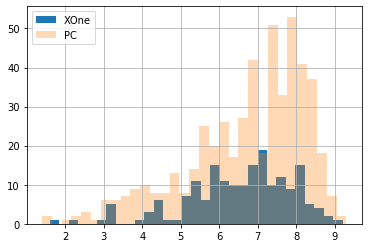

In [33]:
stat, p_1 = normaltest(user_score_x_one)
stat, p_2 = normaltest(user_score_pc)
if (p_1 < 0.05):
    print('user_score_x_one имеет отличное от нормального распределение')
else:
    print('user_score_x_one имеет нормальное распределение')
if (p_2 < 0.05):
    print('user_score_pc имеет отличное от нормального распределение')
else:
    print('user_score_pc имеет нормальное распределение')    
print('Распределение пользовательской оценки')
user_score_x_one.hist(bins = 31, label='XOne')
user_score_pc.hist(bins = 31, alpha = 0.3,label='PC')
plt.legend()
plt.show()

Распределения похожи на Гауссовские, но не совсем. Они подобны и имеют разную диссперсию. Попробуем использовать Дисперсионный анализ(ANOVA). Затем попробуем тест Стьюдента и сравним.

In [34]:
# Дисперсионный анализ
alpha = 0.05
stat, p = f_oneway(user_score_x_one, user_score_pc)
print('p-значение:',p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу, рейтинги разные")
else:
    print("Не получилось отвергнуть нулевую гипотезу, рейтинги в среднем одинаковы")

p-значение: 0.12954586110614363
Не получилось отвергнуть нулевую гипотезу, рейтинги в среднем одинаковы


In [35]:
# t-тест
results = st.ttest_ind(user_score_x_one, user_score_pc, equal_var = False)
print('p-значение:',results.pvalue )
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, рейтинги разные")
else:
    print("Не получилось отвергнуть нулевую гипотезу, рейтинги в среднем одинаковы")

p-значение: 0.11111296036738469
Не получилось отвергнуть нулевую гипотезу, рейтинги в среднем одинаковы


<div style="border:solid green 2px; padding: 20px"> <b>Отличная работа</b><br>
Очень круто, что ты сделала проверку на нормальность и в соответствии с этим выбрала тест для проверки. <br>
Как доп материал, <a href="http://storage.yandexcloud.net/public-bucket-6/%D0%9F%D0%BE%D1%87%D0%B5%D0%BC%D1%83_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B4%D0%BB%D1%8F_%D1%81%D1%82%D0%B0%D1%82_%D1%82%D0%B5%D1%81%D1%82%D0%B0_%D0%BD%D0%B5_%D0%B4%D0%BE%D0%BB%D0%B6%D0%BD%D1%8B_%D0%B1%D1%8B%D1%82%D1%8C_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D1%8B_%D0%BD%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE.pdf">документ</a></div> <br>

<b>Вопрос: Средние пользовательские рейтинги жанров Action и Sports разные?</b>

Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports равны.
Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports не равны.  
Уровень ститистической значимости - 0,05.

In [36]:
user_score_action = df.query('(genre == "Action")&(year_of_release > 2007)')['user_score']
user_score_sport = df.query('genre == "Sports"&(year_of_release > 2007)')['user_score']
user_score_action.dropna(inplace=True)
user_score_sport.dropna(inplace=True)

In [37]:
if (user_score_action.var()) == (user_score_sport.var()):
    print('Дисперсии равны')
else:
    print('Дисперсии не равны')
print('Дисперсия Action:', user_score_action.var())
print('Дисперсия Sport:', user_score_sport.var())

Дисперсии не равны
Дисперсия Action: 1.8014074760580783
Дисперсия Sport: 2.927132150331709


user_score_action имеет отличное от нормального распределение
user_score_sport имеет отличное от нормального распределение
Распределение пользовательской оценки


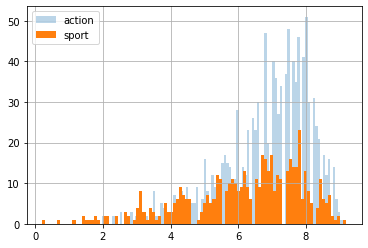

In [38]:
stat, p_1 = normaltest(user_score_action)
stat, p_2 = normaltest(user_score_sport)
if (p_1 < 0.05):
    print('user_score_action имеет отличное от нормального распределение')
else:
    print('user_score_action имеет нормальное распределение')
if (p_2 < 0.05):
    print('user_score_sport имеет отличное от нормального распределение')
else:
    print('user_score_sport имеет нормальное распределение')    
print('Распределение пользовательской оценки')
user_score_action.hist(bins = 100, label='action',alpha = 0.3)
user_score_sport.hist(bins = 100,label='sport')
plt.legend()
plt.show()

Распределения похожи на Гауссовские, но не совсем. Они подобны и имеют разную диссперсию. Попробуем использовать Дисперсионный анализ(ANOVA). Затем попробуем тест Стьюдента и сравним.

In [39]:
# t-тест
alpha = 0.05
results = st.ttest_ind(user_score_action, user_score_sport, equal_var = False)
print('p-значение:',results.pvalue )
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, рейтинги разные")
else:
    print("Не получилось отвергнуть нулевую гипотезу, рейтинги в среднем одинаковы")

p-значение: 4.910932152133618e-13
Отвергаем нулевую гипотезу, рейтинги разные


In [40]:
# Дисперсионный анализ
alpha = 0.05
stat, p = f_oneway(user_score_action, user_score_sport)
print('p-значение:',p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу, рейтинги разные")
else:
    print("Не получилось отвергнуть нулевую гипотезу, рейтинги в среднем одинаковы")

p-значение: 1.9150743334554314e-15
Отвергаем нулевую гипотезу, рейтинги разные


### Общий вывод

<a id='step_6'></a>

На что стоит обратить внимание в 2017 году:
    - в различных регионах набирают популярность игры на платформах XOne(na), PS4(eu), 3DS(jp);
    - самые продаваемы жанры Action, Shooter, Sports и Role-Playing;
    - стоит больше продавать игр с рейтингом ESRB "для всех" и "для взрослых";
    - рейтинги критиков и пользователей чаще всего совпадают;
    - игры с хорошими отзывами критиков продаются лучше.